# What is Survival Analysis?

[Survival analysis](https://en.wikipedia.org/wiki/Survival_analysis) is used to study the **time** until some **event** of interest (often referred to as **death**) occurs.  Time could be measured in years, months, weeks, days, etc.  The event could be anything of interest.  It could be an actual death, a birth, a Pokemon Go server crash, etc. In this post we are interested in how long drafted NFL players are in the league, so the event of interest will be the retirement of drafted NFL players. The duration of time leading up to the event of interest can be called the **survival time**. In our case, the survival time is the number of years that a player was active in the league (according to [Pro Football Reference](http://www.pro-football-reference.com/)).  

Some of the players in this analysis are still active players (e.g. Aaron Rodgers, Eli Manning, etc.), so we haven't observed their retirement (the event of interest).  Those players are considered **censored**. While we have some information about their career length (or survival time), we don't know the full length of their career.  This specific type of censorship, one in which we do not observe end of the survival time, is called **right-censorship**.  The methods developed in the field of survival analysis were created in order to deal with the issue of censored data.  In this post we will use one such method, called the [Kaplan-Meier estimator](https://en.wikipedia.org/wiki/Kaplan%E2%80%93Meier_estimator), to estimate the survival function and construct the survival curve for an NFL career.

# Estimating the Survival Function of Political Regimes

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [22]:
from lifelines.datasets import load_dd

data = load_dd()
data.head()

,ctryname,cowcode2,politycode,un_region_name,un_continent_name,ehead,leaderspellreg,democracy,regime,start_year,duration,observed
0,Afghanistan,700,700.0,Southern Asia,Asia,Mohammad Zahir Shah,Mohammad Zahir Shah.Afghanistan.1946.1952.Mona...,Non-democracy,Monarchy,1946,7,1
1,Afghanistan,700,700.0,Southern Asia,Asia,Sardar Mohammad Daoud,Sardar Mohammad Daoud.Afghanistan.1953.1962.Ci...,Non-democracy,Civilian Dict,1953,10,1
2,Afghanistan,700,700.0,Southern Asia,Asia,Mohammad Zahir Shah,Mohammad Zahir Shah.Afghanistan.1963.1972.Mona...,Non-democracy,Monarchy,1963,10,1
3,Afghanistan,700,700.0,Southern Asia,Asia,Sardar Mohammad Daoud,Sardar Mohammad Daoud.Afghanistan.1973.1977.Ci...,Non-democracy,Civilian Dict,1973,5,0
4,Afghanistan,700,700.0,Southern Asia,Asia,Nur Mohammad Taraki,Nur Mohammad Taraki.Afghanistan.1978.1978.Civi...,Non-democracy,Civilian Dict,1978,1,0


In [23]:
mask1 = data["ctryname"] == "Brazil"


data[mask1]

,ctryname,cowcode2,politycode,un_region_name,un_continent_name,ehead,leaderspellreg,democracy,regime,start_year,duration,observed
198,Brazil,140,140.0,South America,Americas,Eurico Dutra,Eurico Dutra.Brazil.1946.1950.Presidential Dem,Democracy,Presidential Dem,1946,5,1
199,Brazil,140,140.0,South America,Americas,Getulio Vargas,Getulio Vargas.Brazil.1951.1953.Presidential Dem,Democracy,Presidential Dem,1951,3,0
200,Brazil,140,140.0,South America,Americas,Joao Cafe,Joao Cafe.Brazil.1954.1954.Presidential Dem,Democracy,Presidential Dem,1954,1,1
201,Brazil,140,140.0,South America,Americas,Nereu Ramos,Nereu Ramos.Brazil.1955.1955.Presidential Dem,Democracy,Presidential Dem,1955,1,1
202,Brazil,140,140.0,South America,Americas,Juscelino Kubitschek,Juscelino Kubitschek.Brazil.1956.1960.Presiden...,Democracy,Presidential Dem,1956,5,1
203,Brazil,140,140.0,South America,Americas,Tancredo de Almeida Neves,Tancredo de Almeida Neves.Brazil.1961.1961.Mix...,Democracy,Mixed Dem,1961,1,1
204,Brazil,140,140.0,South America,Americas,Hermes Lima,Hermes Lima.Brazil.1962.1962.Mixed Dem,Democracy,Mixed Dem,1962,1,1
205,Brazil,140,140.0,South America,Americas,Joao Belchior Marques Goulart,Joao Belchior Marques Goulart.Brazil.1963.1963...,Democracy,Presidential Dem,1963,1,1
206,Brazil,140,140.0,South America,Americas,Humberto de Alencar Castello Branco,Humberto de Alencar Castello Branco.Brazil.196...,Non-democracy,Military Dict,1964,3,1
207,Brazil,140,140.0,South America,Americas,Artur da Costa e Silva,Artur da Costa e Silva.Brazil.1967.1968.Milita...,Non-democracy,Military Dict,1967,2,1


To calculate the Kaplan-Meier estimate we will need to create a `KaplanMeierFitter` object.

In [24]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

We can then fit the data by calling the `KaplanMeierFitter`s `fit` method.

In [25]:
T = data["duration"]
E = data["observed"]

kmf.fit(T, event_observed=E)

<lifelines.KaplanMeierFitter: fitted with 1808 total observations, 340 right-censored observations>

After fitting our data we can access the event table that contains a bunch of information regarding the subjects at each time period.

In [32]:
kmf.event_table

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.0,0,0,0,275,275
1.0,113,104,9,0,275
2.0,72,59,13,0,162
3.0,36,33,3,0,90
4.0,21,19,2,0,54
5.0,8,8,0,0,33
6.0,6,4,2,0,25
7.0,9,7,2,0,19
8.0,3,2,1,0,10


In [34]:
# get the values for time = 0 from the survival table
event_at_0 = kmf.event_table.iloc[0, :]
# now calculate the survival probability for t = 0
surv_for_0 =  (event_at_0.at_risk - event_at_0.observed) / event_at_0.at_risk
surv_for_0

1.0

In [35]:
# Calculate the survival probability for t = 1
event_at_1 = kmf.event_table.iloc[1, :]
surv_for_1 =  (event_at_1.at_risk - event_at_1.observed) / event_at_1.at_risk
surv_for_1

0.6218181818181818

In [38]:
# Calculate the survival probability for t = 2
event_at_2 = kmf.event_table.iloc[2, :]
surv_for_2 =  (event_at_2.at_risk - event_at_2.observed) / event_at_2.at_risk
surv_for_2

0.6358024691358025

In [39]:
# The probability that an NFL player has a career longer than 2 years
surv_after_2 = surv_for_0 * surv_for_1 * surv_for_2
surv_after_2

0.3953535353535354

In [37]:
kmf.survival_function_

,Mixed Dem
timeline,
0.0,1.000000
1.0,0.621818
2.0,0.395354
3.0,0.250391
4.0,0.162290
5.0,0.122947
6.0,0.103276
7.0,0.065227
8.0,0.052181


## Plotting the Kaplan-Meier Estimate

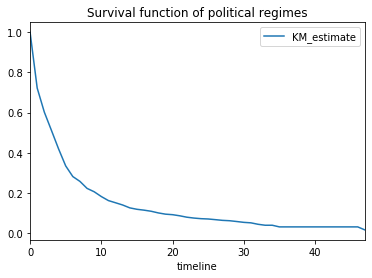

In [26]:
kmf.survival_function_.plot()
plt.title('Survival function of political regimes');

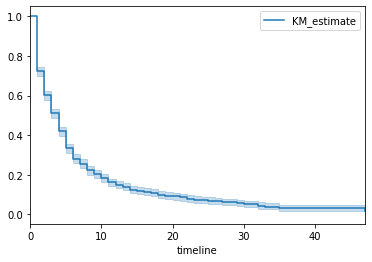

In [27]:
kmf.plot()

### Plotting the Kaplan-Meier Estimate by Regimes

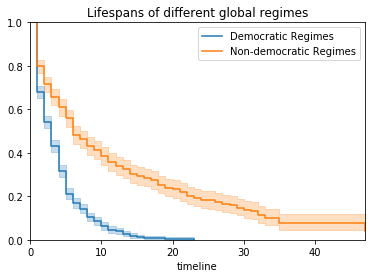

In [28]:
ax = plt.subplot(111)

dem = (data["democracy"] == "Democracy")

kmf.fit(T[dem], event_observed=E[dem], label="Democratic Regimes")
kmf.plot(ax=ax)
kmf.fit(T[~dem], event_observed=E[~dem], label="Non-democratic Regimes")
kmf.plot(ax=ax)

plt.ylim(0, 1);
plt.title("Lifespans of different global regimes");

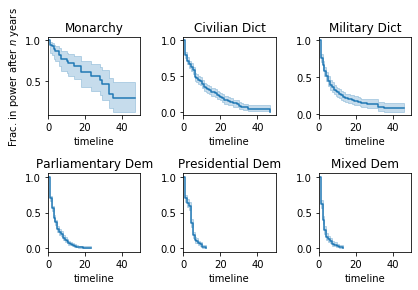

In [41]:
regime_types = data['regime'].unique()

for i, regime_type in enumerate(regime_types):
    ax = plt.subplot(2, 3, i + 1)

    ix = data['regime'] == regime_type
    kmf.fit(T[ix], E[ix], label=regime_type)
    kmf.plot(ax=ax, legend=False)

    plt.title(regime_type)
    plt.xlim(0, 50)


    if i==0:
        plt.ylabel('Frac. in power after $n$ years')

plt.tight_layout()